In [ ]:
###gpu code 
#Change the runtime type to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.798952939000003
GPU (s):
0.19292098200003238
GPU speedup over CPU: 19x


In [ ]:
#Importing required packages
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle


In [ ]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
#If you're data is in google drive use this code
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9f77566940> False
<keras.layers.convolutional.Conv2D object at 0x7f9f775661d0> False
<keras.layers.convolutional.Conv2D object at 0x7f9f77566780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9f79d491d0> False
<keras.layers.convolutional.Conv2D object at 0x7f9f79d49208> False
<keras.layers.convolutional.Conv2D object at 0x7f9f7797fcc0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9f7767b860> False
<keras.layers.convolutional.Conv2D object at 0x7f9f7767b470> False
<keras.layers.convolutional.Conv2D object at 0x7fa141a18048> False
<keras.layers.convolutional.Conv2D object at 0x7fa141a21b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9f72ce25c0> False
<keras.layers.convolutional.Conv2D object at 0x7f9f72ce2400> False
<keras.layers.convolutional.Conv2D object at 0x7f9f72ce2e48> False
<keras.layers.convolutional.Conv2D object at 0x7f9f72d02c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9f72cd1710>

In [ ]:
 from glob import glob
 # useful for getting number of classes
folders = glob("/content/drive/My Drive/data/Images/*")
print(len(folders))

21


In [ ]:
from keras import models
from keras import layers
from keras import optimizers
# Create the model

model = models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(folders), activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1096)              27497544  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 21)                23037     
Total params: 42,235,269
Trainable params: 34,600,005
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
train_path = '/content/drive/My Drive/data/train'
valid_path = '/content/drive/My Drive/data/test'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
 

train_batchsize = 32
val_batchsize = 32

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/data/train',
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/data/test',
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(train_generator) ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps= len(validation_generator),
      verbose=1)

# Save the model
model.save('small_last4.h5')

Epoch 1/15
53/53 [==============================] - 22s 424ms/step - loss: 1.7521 - acc: 0.4714 - val_loss: 2.1960 - val_acc: 0.7429
Epoch 2/15
53/53 [==============================] - 21s 402ms/step - loss: 0.7963 - acc: 0.7452 - val_loss: 0.7464 - val_acc: 0.8548
Epoch 3/15
53/53 [==============================] - 21s 397ms/step - loss: 0.5830 - acc: 0.8179 - val_loss: 0.5798 - val_acc: 0.8167
Epoch 4/15
53/53 [==============================] - 21s 398ms/step - loss: 0.4319 - acc: 0.8565 - val_loss: 0.4977 - val_acc: 0.8500
Epoch 5/15
53/53 [==============================] - 21s 399ms/step - loss: 0.3378 - acc: 0.8964 - val_loss: 0.0487 - val_acc: 0.8619
Epoch 6/15
53/53 [==============================] - 21s 399ms/step - loss: 0.2870 - acc: 0.9077 - val_loss: 0.0079 - val_acc: 0.8714
Epoch 7/15
53/53 [==============================] - 21s 396ms/step - loss: 0.2656 - acc: 0.9155 - val_loss: 1.5189e-04 - val_acc: 0.8810
Epoch 8/15
53/53 [==============================] - 21s 397ms/ste

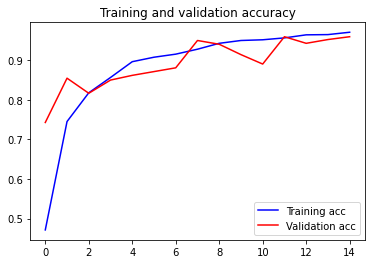

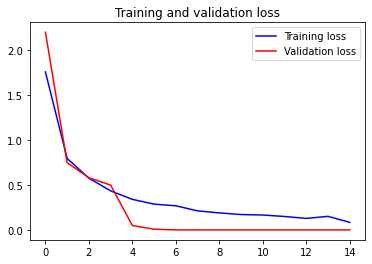

In [ ]:
#Code to plot the accuracy and loss graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Found 420 images belonging to 21 classes.
14/14 [==============================] - 1s 89ms/step
No of errors = 17/420


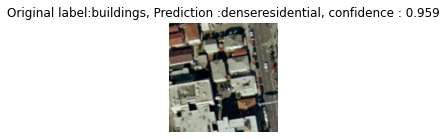

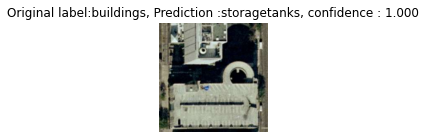

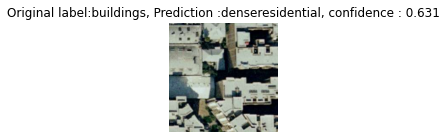

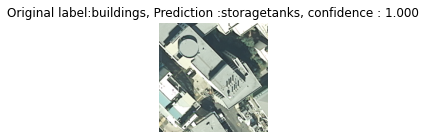

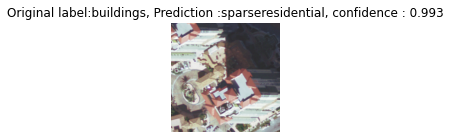

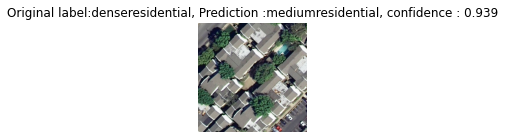

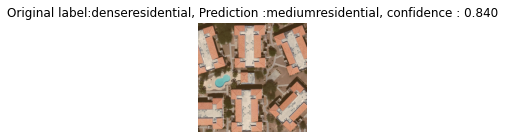

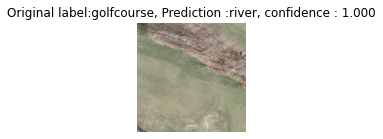

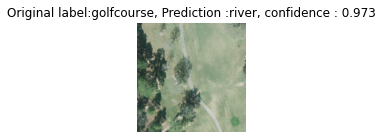

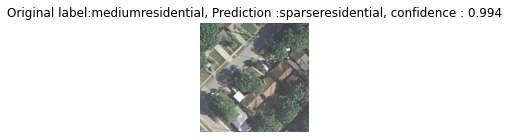

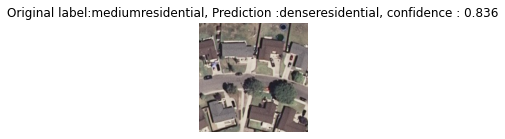

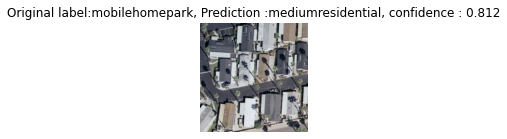

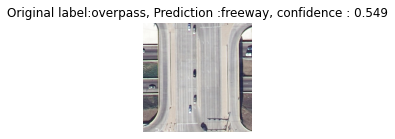

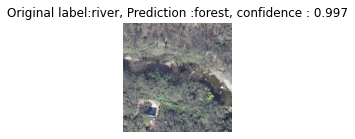

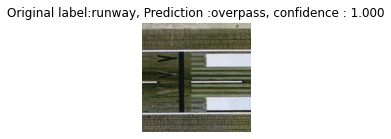

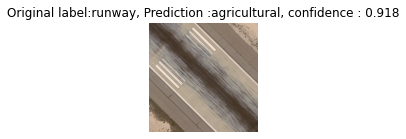

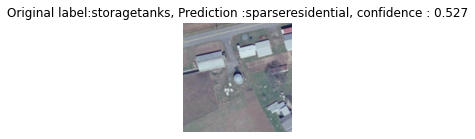

In [ ]:
#Code to validate the testset
from keras.preprocessing.image import load_img
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/data/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames
# Get the ground truth from generator
ground_truth = validation_generator.classes
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=len(validation_generator),verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    original = load_img('{}/{}'.format('/content/drive/My Drive/data/test',fnames[errors[i]]))
    plt.figure(figsize=[2,2])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

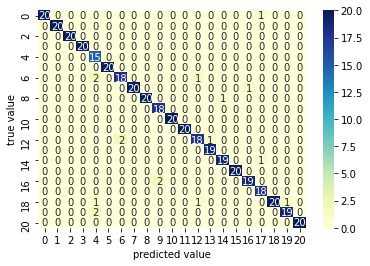

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(predicted_classes, ground_truth)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');